Lecture: AI I - Advanced 

Previous:
[**Chapter 3.1: PyTorch Lightning**](../../03_advanced/01_ligthning.ipynb)

---

# Chapter 4.1.1: Computer Vision with Convolutional Neural Networks

In Chapter 2, PyTorch Lightning showed you how to organise and automate the training loop — separating data, model, and optimisation logic into clean, reusable blocks. You've been working with tabular data ever since the beginning: the Iris dataset, with its four numerical features per sample, fed directly into fully-connected layers.

Now we step into a completely different world: images. Images aren't rows of numbers in a table — they are grids of pixels, and the spatial arrangement of those pixels carries meaning. A stroke in the top-left corner of a digit and a stroke in the bottom-right corner together form a specific shape, but only because of where they are relative to each other. A fully-connected network has no way to exploit this structure. It sees a flat list of numbers and has to learn spatial relationships from scratch, which is expensive and wasteful.

This excursion introduces **Convolutional Neural Networks (CNNs)** — architectures specifically designed for grid-structured data like images. We start with the simplest possible image dataset, solve it first with a plain feedforward network to establish a baseline, and then build up to a CNN that is architecturally inspired by AlexNet, one of the models that kicked off the modern deep learning era.

## The MNIST Dataset

MNIST (Modified National Institute of Standards and Technology) is the "Hello World" of machine learning. It contains 70,000 handwritten digit images, each one a 28×28 pixel grayscale image of a single digit from 0 to 9.

| Property | Value |
|----------|-------|
| Training images | 60,000 |
| Test images | 10,000 |
| Image size | 28×28 pixels |
| Color channels | 1 (grayscale) |
| Classes | 10 (digits 0–9) |
| Pixel value range | 0 (Black) – 255 (White) |

Each image is stored as a 2D grid of pixel intensities. The digit "3", for example, is not defined by a single pixel value — it's defined by the pattern of bright pixels against a dark background. That pattern has structure: curves, lines, and their spatial relationships. This is exactly the kind of information that CNNs are built to capture.

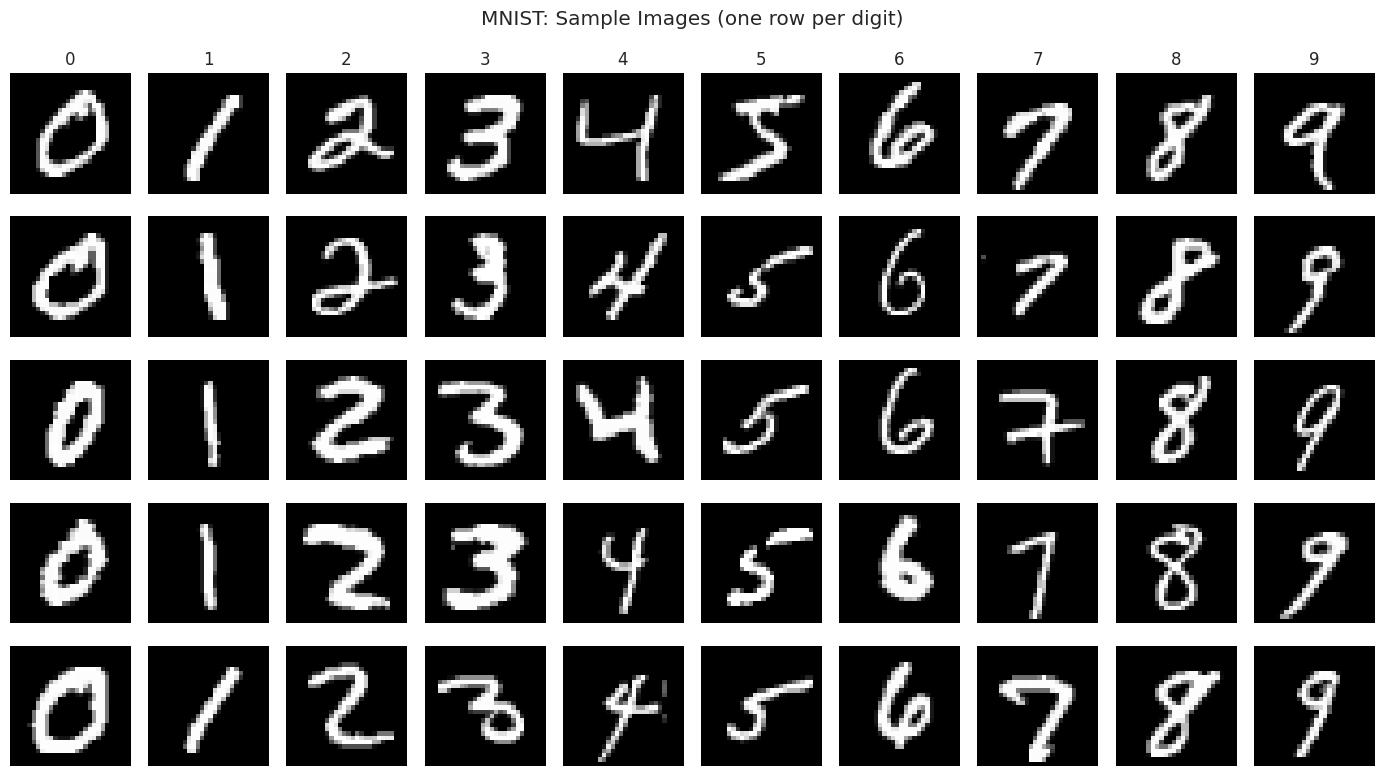

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),   # PIL Image (H, W) → Tensor (1, H, W), scales to [0, 1]
])

train_dataset = datasets.MNIST(root="./data/01_cnn", train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data/01_cnn", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(5, 10, figsize=(14, 8))

samples_per_digit = {d: [] for d in range(10)}
for img, label in train_dataset:
    if len(samples_per_digit[label]) < 5:
        samples_per_digit[label].append(img)
    if all(len(v) == 5 for v in samples_per_digit.values()):
        break

for row in range(5):
    for col in range(10):
        axes[row, col].imshow(samples_per_digit[col][row].squeeze(), cmap="gray")
        axes[row, col].axis("off")
        if row == 0:
            axes[row, col].set_title(str(col))

fig.suptitle("MNIST: Sample Images (one row per digit)")
fig.tight_layout()

## Solving MNIST with a Feedforward Network

Before we introduce CNNs, let's solve MNIST the "naive" way — with a plain feedforward network, the same architecture we've been using since Chapter 1. This gives us a baseline to compare against and makes the limitations of fully-connected layers on image data concrete.

### The Flatten Problem

A fully-connected (`nn.Linear`) layer expects a 1D vector as input. But our images are 2D grids (28×28). To feed an image into a Linear layer, we have to flatten it: reshape the 28×28 grid into a single vector of 784 numbers.

This works — the network can learn to classify digits from a flat vector — but it has to discover spatial patterns entirely from scratch, which requires more parameters and more data than necessary. CNNs solve this by operating directly on the 2D structure.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardClassifier(nn.Module):

    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super().__init__()
        self.flatten  = nn.Flatten()
        self.fc1      = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2      = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3      = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Instantiate and count parameters
model = FeedforwardClassifier()
total_params = sum(p.numel() for p in model.parameters())
print(f"Feedforward model parameters: {total_params:,}")

Feedforward model parameters: 269,322


### Training and Evaluation Helper

We'll reuse this helper for both the feedforward and CNN models so the comparison is fair.

In [3]:
import torch

def train_and_evaluate(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train a model and return history + final test accuracy."""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses,  test_accs  = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            logits = model(images)
            loss   = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            correct    += (logits.argmax(dim=1) == labels).sum().item()
            total      += images.size(0)

        train_losses.append(epoch_loss / total)
        train_accs.append(correct / total)

        model.eval()
        eval_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                logits = model(images)
                loss   = criterion(logits, labels)

                eval_loss += loss.item() * images.size(0)
                correct   += (logits.argmax(dim=1) == labels).sum().item()
                total     += images.size(0)

        test_losses.append(eval_loss / total)
        test_accs.append(correct / total)

        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}  Acc: {train_accs[-1]:.4f} | "
              f"Test Loss:  {test_losses[-1]:.4f}  Acc: {test_accs[-1]:.4f}")

    return {
        "train_loss": train_losses, "train_acc": train_accs,
        "test_loss":  test_losses,  "test_acc":  test_accs,
    }


history = train_and_evaluate(model, train_loader, test_loader, epochs=10)

Epoch  1/10 | Train Loss: 0.3168  Acc: 0.9047 | Test Loss:  0.1299  Acc: 0.9606
Epoch  2/10 | Train Loss: 0.1394  Acc: 0.9577 | Test Loss:  0.0935  Acc: 0.9695
Epoch  3/10 | Train Loss: 0.1065  Acc: 0.9667 | Test Loss:  0.0793  Acc: 0.9756
Epoch  4/10 | Train Loss: 0.0909  Acc: 0.9719 | Test Loss:  0.0736  Acc: 0.9769
Epoch  5/10 | Train Loss: 0.0763  Acc: 0.9759 | Test Loss:  0.0729  Acc: 0.9768
Epoch  6/10 | Train Loss: 0.0701  Acc: 0.9773 | Test Loss:  0.0680  Acc: 0.9778
Epoch  7/10 | Train Loss: 0.0621  Acc: 0.9808 | Test Loss:  0.0698  Acc: 0.9792
Epoch  8/10 | Train Loss: 0.0567  Acc: 0.9819 | Test Loss:  0.0670  Acc: 0.9816
Epoch  9/10 | Train Loss: 0.0545  Acc: 0.9821 | Test Loss:  0.0683  Acc: 0.9806
Epoch 10/10 | Train Loss: 0.0493  Acc: 0.9841 | Test Loss:  0.0733  Acc: 0.9803


## Why Feedforward Networks Are Wasteful on Images

Before we move to CNNs, let's make the problem concrete. Look at what happens when you flatten an image and feed it into a fully-connected layer:

**Parameter explosion**: The first Linear layer alone needs 784 × 256 = 200,704 weights. Every single input pixel is connected to every single neuron. Most of these connections are meaningless — pixel [0, 0] (top-left corner) has nothing to do with pixel [27, 27] (bottom-right corner), but the network dedicates a learnable weight to their connection anyway.

**No spatial awareness**: After flattening, the network treats the pixel sequence as arbitrary. If you permuted the pixels randomly (shuffled their positions), the network would need to relearn everything from scratch. A CNN, by contrast, would break immediately — because it relies on spatial structure.

**No weight sharing**: The same visual pattern (say, a curved stroke) can appear anywhere in the image. A fully-connected layer learns a separate set of weights for detecting that pattern at each position. A CNN uses the same weights everywhere — a huge efficiency gain.

This is the motivation for convolutions. They are not just "another layer type" — they are a fundamentally different way of processing grid-structured data.

## Convolutions: The Core Idea

A convolution slides a small kernel (also called a filter) across the image and computes a dot product at every position. The kernel is typically small — $3×3$ or $5×5$ — and it captures a local pattern.

Think of it as a magnifying glass with a fixed pattern printed on it. You slide it over every patch of the image. Where the image matches the pattern, the output is high. Where it doesn't match, the output is low. The result is a new 2D grid — called a feature map — that highlights where that particular pattern appeared in the original image.

```
Input image (5×5)        Kernel (3×3)         
                                              
┌───┬───┬───┬───┬───┐   ┌───┬───┬───┐        
│ 1 │ 2 │ 3 │ 0 │ 1 │   │-1 │ 0 │ 1 │        This 3×3 kernel slides
├───┼───┼───┼───┼───┤   ├───┼───┼───┤        across the input image.
│ 0 │ 1 │ 2 │ 1 │ 0 │   │-1 │ 0 │ 1 │        
├───┼───┼───┼───┼───┤   ├───┼───┼───┤        At each position, we compute
│ 2 │ 1 │ 0 │ 1 │ 2 │   │-1 │ 0 │ 1 │        the dot product between the
├───┼───┼───┼───┼───┤   └───┴───┴───┘        kernel and the 3×3 patch of
│ 1 │ 0 │ 1 │ 2 │ 1 │                        the image under it.
├───┼───┼───┼───┼───┤   
│ 0 │ 1 │ 2 │ 0 │ 1 │   This particular kernel
└───┴───┴───┴───┴───┘   detects vertical edges.


Example: sliding the kernel over position (0,0) of the input
┌───┬───┬───┐
│ 1 │ 2 │ 3 │  ×  kernel  =  (1×-1) + (2×0) + (3×1)
├───┼───┼───┤             +  (0×-1) + (1×0) + (2×1)
│ 0 │ 1 │ 2 │             +  (2×-1) + (1×0) + (0×1)  =  2
├───┼───┼───┤
│ 2 │ 1 │ 0 │
└───┴───┴───┘

After sliding across all valid positions → 3×3 output feature map
```

The kernel above (−1, 0, +1 repeated vertically) is a classic edge detector: it computes the difference between the left and right sides of each 3×3 patch. Where there's a sharp transition from dark to bright (a vertical edge), the output is large. Where the image is uniform, the output is near zero.

### Key Properties

**Weight sharing**: The same kernel is applied at every position in the image. A 3×3 kernel has only 9 learnable weights, regardless of image size. Compare this to a fully-connected layer, which needs a separate weight for every input-output pair.

**Local connectivity**: Each output value depends on only a small neighbourhood (3×3 or 5×5 pixels), not the entire image. This is a strong inductive bias: nearby pixels are more likely to be related than distant pixels.

**Learned kernels**: In a trained CNN, the kernels are not hand-designed — they are learned during backpropagation, just like any other weights. Early layers typically learn simple patterns (edges, corners), and deeper layers combine these into increasingly complex features (curves, textures, object parts).

### Visualising Learned Kernels

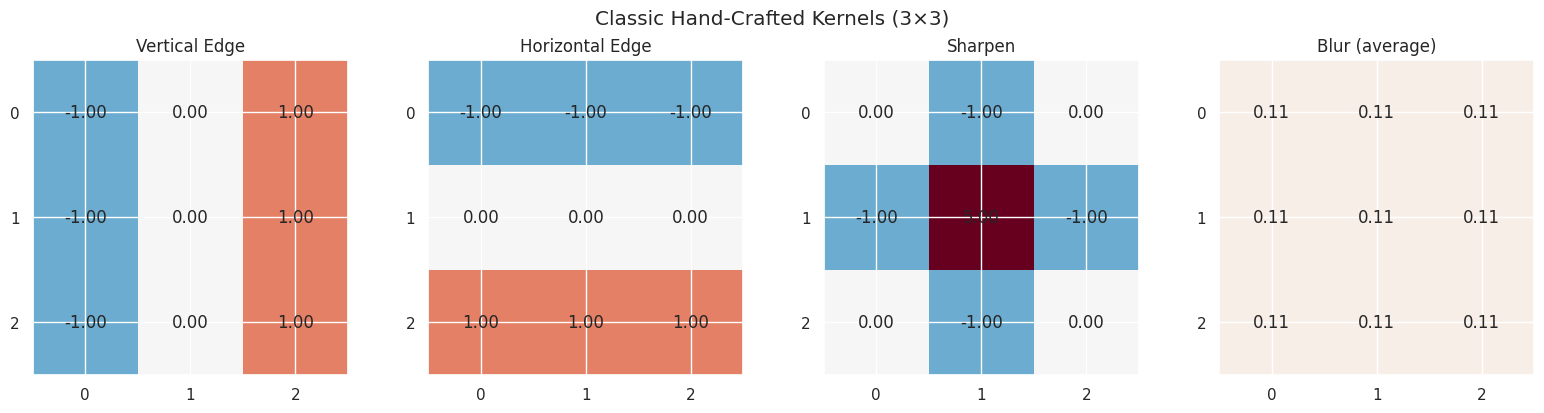

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Classic Hand-Crafted Kernels (3×3)")

kernels = {
    "Vertical Edge":   [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
    "Horizontal Edge": [[-1,-1,-1], [ 0, 0, 0], [ 1, 1, 1]],
    "Sharpen":         [[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]],
    "Blur (average)":  [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]],
}

for ax, (name, kernel) in zip(axes, kernels.items()):
    ax.imshow(kernel, cmap="RdBu_r", vmin=-2, vmax=2, aspect="equal")
    ax.set_title(name)
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{kernel[i][j]:.2f}", ha="center", va="center",)

fig.tight_layout()

## Pooling: Shrinking Feature Maps

Convolutions preserve (or nearly preserve) the spatial size of the input. After several conv layers, the feature maps are still large — and stacking more layers on top gets expensive fast. Pooling solves this by downsampling the feature map while retaining the most important information.

### Max Pooling

The most common type. The feature map is divided into non-overlapping patches (typically 2×2), and the maximum value in each patch is kept. This halves both dimensions: a 28×28 feature map becomes 14×14.

```
Feature map (4×4)          Split into 2×2 patches         Take max of each

┌───┬───┬───┬───┐         ┌───────┬───────┐             ┌───┬───┐
│ 1 │ 3 │ 2 │ 4 │         │ 1   3 │ 2   4 │             │ 5 │ 4 │
├───┼───┼───┼───┤    →    │ 2   5 │ 1   3 │      →      ├───┼───┤
│ 2 │ 5 │ 1 │ 3 │         ├───────┼───────┤             │ 6 │ 5 │
├───┼───┼───┼───┤         │ 4   1 │ 3   2 │             └───┴───┘
│ 4 │ 1 │ 3 │ 2 │         │ 6   2 │ 5   1 │
├───┼───┼───┼───┤         └───────┴───────┘             Output: 2×2
│ 6 │ 2 │ 5 │ 1 │         
└───┴───┴───┴───┘         max(1,3,2,5)=5  max(2,4,1,3)=4    
                          max(4,1,6,2)=6  max(3,2,5,1)=5
```

Why max pooling works: If a feature detector fired strongly somewhere in a 2×2 region, it doesn't matter exactly where — the feature is present. Max pooling preserves that signal while discarding the precise location. This makes the representation slightly translation-invariant: a feature detected one pixel to the left still produces the same output after pooling.

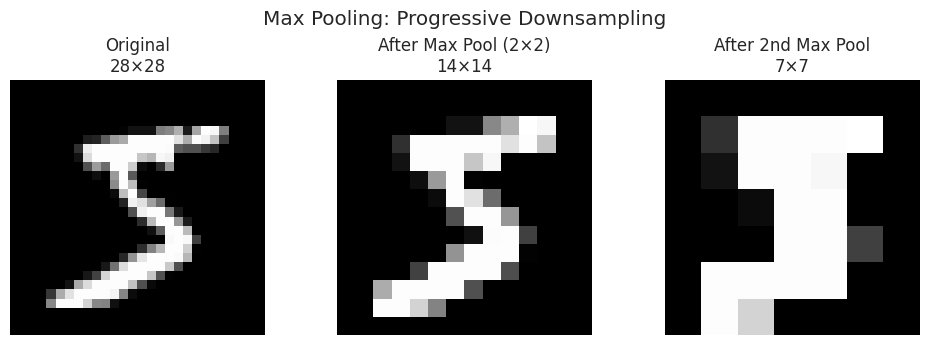

In [ ]:
sample_image = train_dataset[0][0]  # shape: (1, 28, 28)

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

axes[0].imshow(sample_image.squeeze(), cmap="gray")
axes[0].set_title(f"Original\n{sample_image.shape[1]}×{sample_image.shape[2]}")
axes[0].axis("off")

pooled = F.max_pool2d(sample_image.unsqueeze(0), kernel_size=2, stride=2)
axes[1].imshow(pooled.squeeze(), cmap="gray")
axes[1].set_title(f"After Max Pool (2×2)\n{pooled.shape[2]}×{pooled.shape[3]}")
axes[1].axis("off")

pooled2 = F.max_pool2d(pooled, kernel_size=2, stride=2)
axes[2].imshow(pooled2.squeeze(), cmap="gray")
axes[2].set_title(f"After 2nd Max Pool\n{pooled2.shape[2]}×{pooled2.shape[3]}")
axes[2].axis("off")

fig.suptitle("Max Pooling: Progressive Downsampling")
fig.tight_layout()

---

Lecture: AI I - Advanced 

Exercise: [**Exercise 2.1: Python Basics**](../02_python/exercises/01_basics.ipynb)

Next: [**Chapter 4.2.1: Transformers**](../02_nlp/01_gpt2.ipynb)